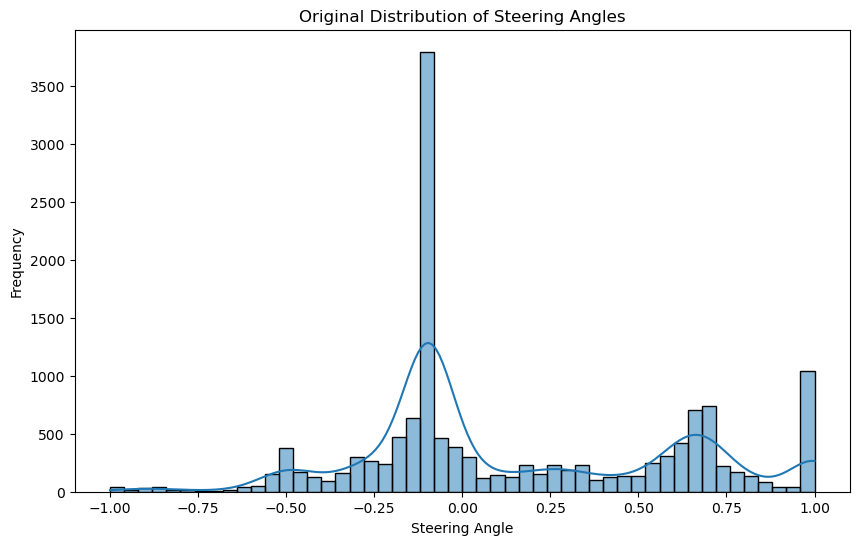

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your data
data_dir = r"C:\Users\User\OneDrive\Desktop\AV Lab\logging_weird_2\logging"
log_file_path = os.path.join(data_dir, "logging_data", "log_file_0.txt")
# Define image base path (directory containing the images)
image_base_path = os.path.join(data_dir, "image_data")

# Read the log file content
with open(log_file_path, 'r') as file:
    log_file_content = file.read()

# Process the log file content
log_lines = log_file_content.strip().split('\n')
data = []
for line in log_lines:
    parts = line.split()
    if len(parts) == 5 and parts[0] != 'Time':
        front_image, left_image, right_image, steering_angle = parts[1:5]
        data.append([front_image, left_image, right_image, float(steering_angle)])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['Front Image', 'Left Image', 'Right Image', 'Steering Angle'])

# Normalize and Standardize the steering angles
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Steering Angle'] = scaler.fit_transform(df['Steering Angle'].values.reshape(-1, 1))

# Plot the original distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Steering Angle'], bins=50, kde=True)
plt.title('Original Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.show()


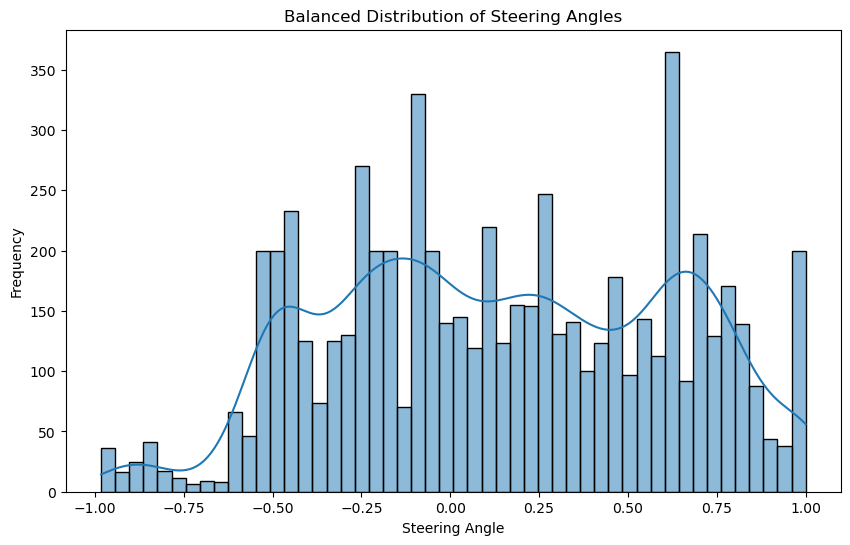

Original data size: 14291
Balanced data size: 6447


In [3]:
# Bucket the steering angles into bins
bins = np.linspace(-1, 1, 50)  # 50 bins between -1 and 1
df['Binned Angle'] = pd.cut(df['Steering Angle'], bins)

# Check the distribution of samples in each bin
bin_counts = df['Binned Angle'].value_counts()

# Set a threshold for maximum samples per bin
max_samples_per_bin = 200  # Adjust based on your desired balance

# Downsample over-represented bins
balanced_df = pd.DataFrame()
for bin_range, count in bin_counts.items():
    bin_samples = df[df['Binned Angle'] == bin_range]
    if count > max_samples_per_bin:
        bin_samples = bin_samples.sample(max_samples_per_bin)  # Randomly sample
    balanced_df = pd.concat([balanced_df, bin_samples])

# Remove the Binned Angle column
balanced_df.drop(columns=['Binned Angle'], inplace=True)

# Plot the balanced distribution
plt.figure(figsize=(10, 6))
sns.histplot(balanced_df['Steering Angle'], bins=50, kde=True)
plt.title('Balanced Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.show()

# Optional: Check the size of the balanced data
print(f'Original data size: {len(df)}')
print(f'Balanced data size: {len(balanced_df)}')


Training data size: 5157
Validation data size: 1290


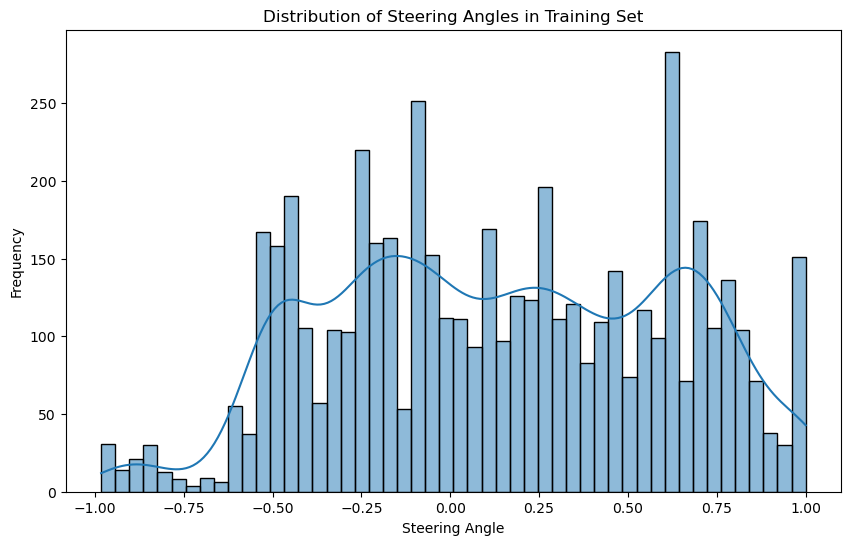

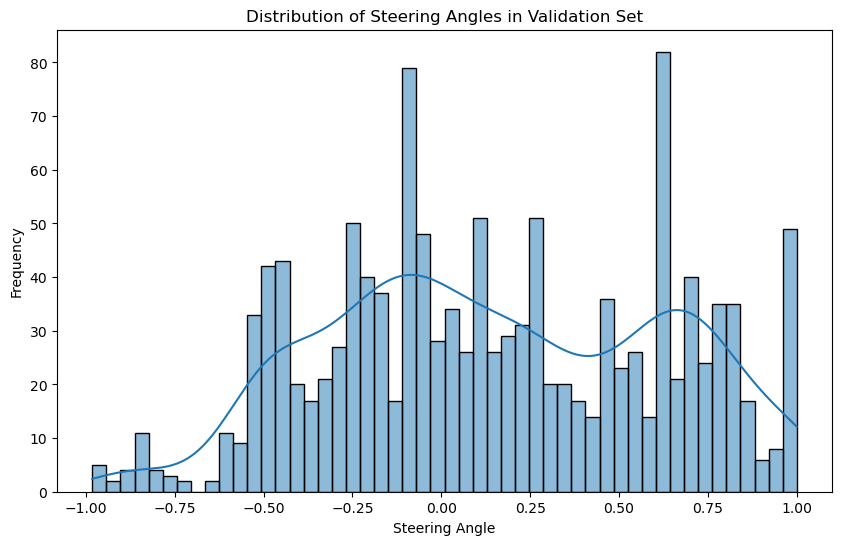

In [7]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into training and validation sets
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42, shuffle=True)

# Optional: Check the size of training and validation datasets
print(f'Training data size: {len(train_df)}')
print(f'Validation data size: {len(val_df)}')

# Plot the distribution of the training set
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Steering Angle'], bins=50, kde=True)
plt.title('Distribution of Steering Angles in Training Set')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the validation set
plt.figure(figsize=(10, 6))
sns.histplot(val_df['Steering Angle'], bins=50, kde=True)
plt.title('Distribution of Steering Angles in Validation Set')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.show()


In [19]:
# Dataset class for loading images and steering angles
class DrivingDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Randomly select between front, left, or right images
        choice = random.choice(['Front Image', 'Left Image', 'Right Image'])
        img_name = os.path.join(self.img_dir, os.path.basename(row[choice]))

        # Verify the image path and handle errors if image doesn't exist or fails to load
        if not os.path.exists(img_name):
            print(f"Image not found: {img_name}")
            return None, None

        image = cv2.imread(img_name)
        if image is None:
            print(f"Failed to read image: {img_name}")
            return None, None

        # Convert the image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get the steering angle
        steering_angle = float(row['Steering Angle'])
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, steering_angle

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert from NumPy array to PIL image
    transforms.Resize((66, 200)),  # Resize to standard input size for model
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Custom collate function to handle missing data
def custom_collate(batch):
    # Filter out None values (images that failed to load)
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch) == 0:  # If entire batch is invalid, return dummy tensors
        return torch.zeros((1, 3, 66, 200)), torch.zeros(1)
    return torch.utils.data.dataloader.default_collate(batch)

# Split the dataset (You should ensure `train_df` and `val_df` are created before this)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Instantiate datasets using the split DataFrames (train_df and val_df)
train_dataset = DrivingDataset(train_df, img_dir=image_base_path, transform=transform)
valid_dataset = DrivingDataset(val_df, img_dir=image_base_path, transform=transform)

# Instantiate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

# Example to check if DataLoader works
for images, angles in train_loader:
    print(f'Batch of images shape: {images.shape}')
    print(f'Batch of steering angles: {angles}')
    break  # Check just one batch for now

Batch of images shape: torch.Size([32, 3, 66, 200])
Batch of steering angles: tensor([ 0.6429, -0.0893, -0.0893,  0.5893,  0.3393, -0.4643,  0.2143, -0.2321,
        -0.0893, -0.1071, -0.0893, -0.1607,  0.7321,  0.2679,  0.6429, -0.1429,
         0.1071, -0.1429, -0.4821, -0.0536, -0.1607, -0.0714,  0.6964,  0.5536,
         1.0000, -0.5357, -0.2143,  1.0000,  0.6250,  0.2143,  0.7500,  0.6250],
       dtype=torch.float64)


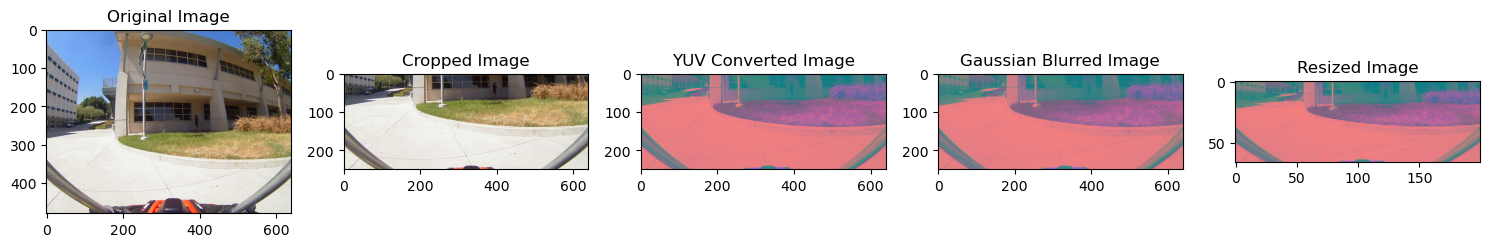

In [37]:
import cv2
import numpy as np
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

# Image Preprocessing Function with Visualization
def img_preprocess(img):
    # Step 1: Original Image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title("Original Image")
    
    # Step 2: Cropping 
    img_cropped = img[200:450, :, :]
    plt.subplot(1, 5, 2)
    plt.imshow(img_cropped)
    plt.title("Cropped Image")
    
    # Step 3: Convert to YUV color space
    img_yuv = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2YUV)
    plt.subplot(1, 5, 3)
    plt.imshow(img_yuv)
    plt.title("YUV Converted Image")
    
    # Step 4: Apply Gaussian Blur
    img_blur = cv2.GaussianBlur(img_yuv, (3, 3), 0)
    plt.subplot(1, 5, 4)
    plt.imshow(img_blur)
    plt.title("Gaussian Blurred Image")
    
    # Step 5: Resize to (200, 66)
    img_resized = cv2.resize(img_blur, (200, 66))
    plt.subplot(1, 5, 5)
    plt.imshow(img_resized)
    plt.title("Resized Image")
    
    # Normalize pixel values to the range [0, 1]
    img_resized = img_resized / 255.0
    
    plt.tight_layout()
    plt.show()
    
    return img_resized

# Random Augmentation (unchanged, no visualization here)
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = iaa.Affine(scale=(1, 1.3)).augment_image(image)
    if np.random.rand() < 0.5:
        image = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}).augment_image(image)
    if np.random.rand() < 0.5:
        image = iaa.Multiply((0.2, 1.2)).augment_image(image)
    if np.random.rand() < 0.5:
        image, steering_angle = cv2.flip(image, 1), -steering_angle
    return image, steering_angle

# Example: Load a random image and preprocess
img_idx = 90  # Select a random image index (or any specific index)
row = train_df.iloc[img_idx]
img_path = os.path.join(image_base_path, os.path.basename(row['Front Image']))
steering_angle = row['Steering Angle']

# Load the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Display the original and preprocessed image step by step
preprocessed_img = img_preprocess(img)


In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
           
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(64*18*1, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
device = torch.device('cpu')
model = NvidiaModel().to(device)

In [162]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_accuracy(predictions, targets, threshold=0.1):
    correct = torch.abs(predictions - targets) < threshold
    accuracy = correct.float().mean().item()
    return accuracy

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    valid_mae = []
    valid_rmse = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for images, steering_angles in train_loader:
            if images is None or steering_angles is None:
                continue

            images, steering_angles = images.to(device), steering_angles.to(device).float() 
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()  
            loss = criterion(outputs, steering_angles)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation Phase
        model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for images, steering_angles in valid_loader:
                if images is None or steering_angles is None:
                    continue
                
                images, steering_angles = images.to(device), steering_angles.to(device).float() 
                outputs = model(images).squeeze() 
                loss = criterion(outputs, steering_angles)
                running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                accuracy = calculate_accuracy(outputs, steering_angles, threshold=0.1)
                correct_predictions += accuracy * images.size(0)
                total_predictions += images.size(0)
                
                # Storing all predictions and targets for MAE and RMSE calculation
                all_predictions.extend(outputs.cpu().numpy())
                all_targets.extend(steering_angles.cpu().numpy())

        epoch_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_loss)

        # Validation accuracy
        accuracy = correct_predictions / total_predictions
        valid_accuracies.append(accuracy)

        # Calculate the MAE and RMSE for validation
        mae = mean_absolute_error(all_targets, all_predictions)
        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        valid_mae.append(mae)
        valid_rmse.append(rmse)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Validation Loss: {epoch_loss:.4f}, '
              f'Validation Accuracy: {accuracy:.4f}, '
              f'Validation MAE: {mae:.4f}, '
              f'Validation RMSE: {rmse:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses, valid_losses, valid_accuracies, valid_mae, valid_rmse

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the model with the updated training loop
train_losses, valid_losses, valid_accuracies, valid_mae, valid_rmse = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=150)


C:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/150, Training Loss: 0.3963
Epoch 1/150, Validation Loss: 0.2042, Validation Accuracy: 0.0535, Validation MAE: 0.3838, Validation RMSE: 0.4519
Epoch 2/150, Training Loss: 0.2014
Epoch 2/150, Validation Loss: 0.2039, Validation Accuracy: 0.0584, Validation MAE: 0.3846, Validation RMSE: 0.4515
Epoch 3/150, Training Loss: 0.1994
Epoch 3/150, Validation Loss: 0.2031, Validation Accuracy: 0.0486, Validation MAE: 0.3876, Validation RMSE: 0.4507
Epoch 4/150, Training Loss: 0.1993
Epoch 4/150, Validation Loss: 0.2033, Validation Accuracy: 0.0486, Validation MAE: 0.3870, Validation RMSE: 0.4508
Epoch 5/150, Training Loss: 0.1991
Epoch 5/150, Validation Loss: 0.2028, Validation Accuracy: 0.0525, Validation MAE: 0.3918, Validation RMSE: 0.4503
Epoch 6/150, Training Loss: 0.1990
Epoch 6/150, Validation Loss: 0.2029, Validation Accuracy: 0.0476, Validation MAE: 0.3937, Validation RMSE: 0.4504
Epoch 7/150, Training Loss: 0.1993
Epoch 7/150, Validation Loss: 0.2028, Validation Accuracy: 0.0472

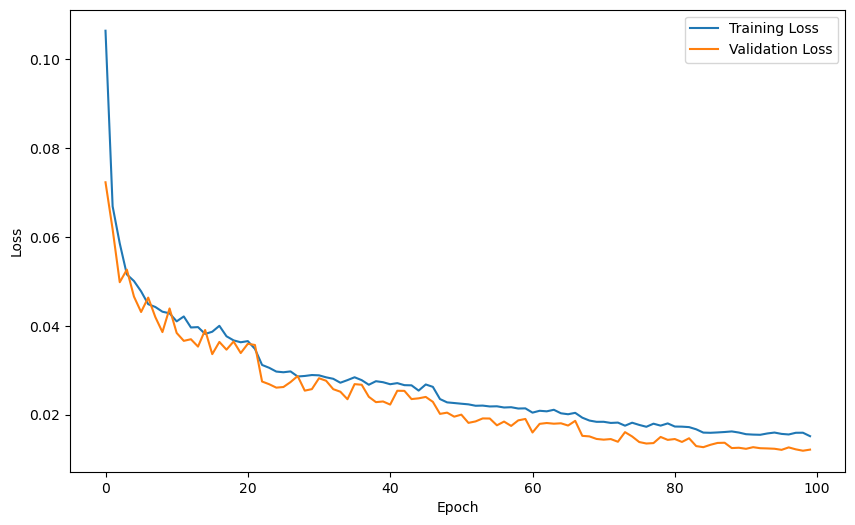

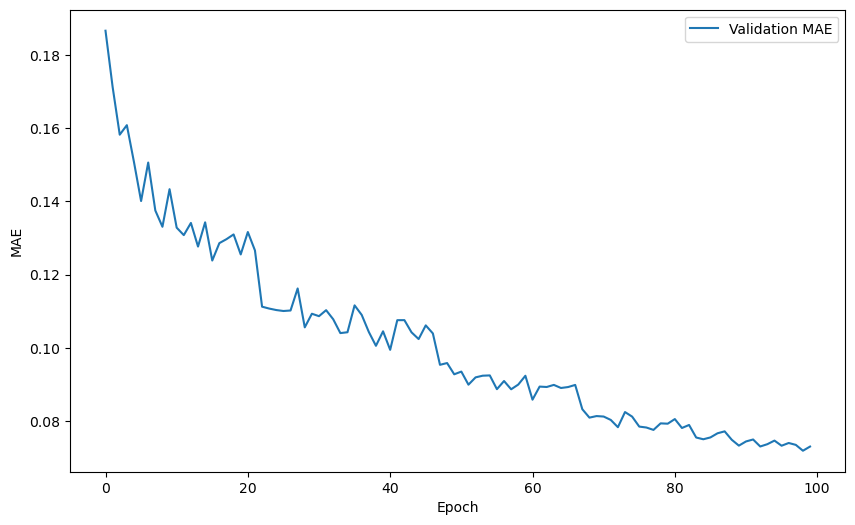

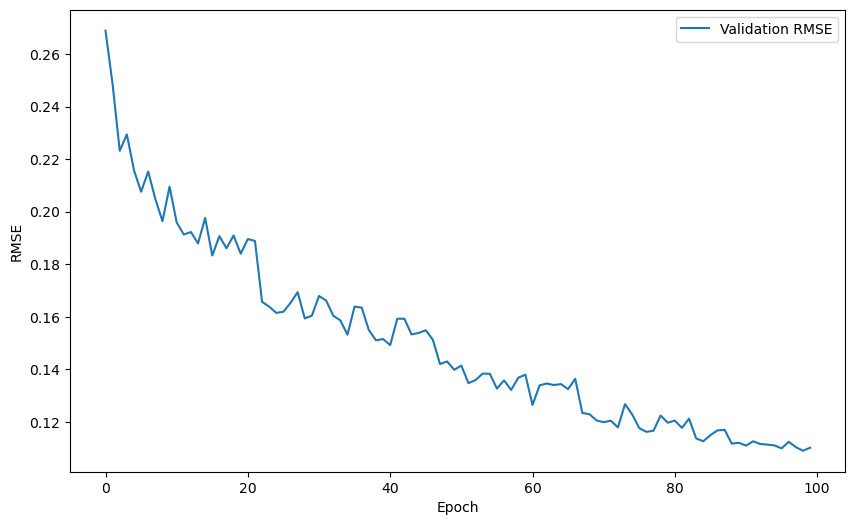

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [112]:
torch.save(model.state_dict(), 'BestModel2.pth')
print("Model saved as 'BestModel2.pth'")


Model saved as 'BestModel2.pth'


# Testing

In [114]:
# Load the model
model = NvidiaModel().to(device)
model.load_state_dict(torch.load('BestModel1.pth'))
model.eval()  # Set the model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_21308\832348227.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('BestModel1.pth'))


NvidiaModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [150]:
# Paths for the new test dataset
new_data_dir = r"C:\Users\User\OneDrive\Desktop\AV Lab\logging5\logging"
new_log_file_path = os.path.join(new_data_dir, "logging_data", "log_file_0.txt")
new_image_base_path = os.path.join(new_data_dir, "image_data")

# Load the new log file
with open(new_log_file_path, 'r') as file:
    log_file_content = file.read()

# Process the log file
log_lines = log_file_content.strip().split('\n')
new_data = []
skipped_lines = 0

for line in log_lines:
    parts = line.split()
    if len(parts) == 5 and parts[0] != 'Time':
        front_image = parts[1]
        left_image = parts[2]
        right_image = parts[3]
        steering_angle = float(parts[4])
        new_data.append([front_image, left_image, right_image, steering_angle])
    else:
        skipped_lines += 1

# Create a pandas DataFrame
new_df = pd.DataFrame(new_data, columns=['Front Image', 'Left Image', 'Right Image', 'Steering Angle'])

# Normalize and Standardize steering angles
new_steering_angles = new_df['Steering Angle'].values

# Normalization (to [-1, 1])
scaler = MinMaxScaler(feature_range=(-1, 1))
new_steering_angles = scaler.fit_transform(new_steering_angles.reshape(-1, 1))

# Standardization (Z-score scaling)
standardizer = StandardScaler()
new_steering_angles = standardizer.fit_transform(new_steering_angles)

# Update the DataFrame with normalized and standardized steering angles
new_df['Steering Angle'] = new_steering_angles

# Driving Dataset class (only loading the front images)
class DrivingDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = os.path.join(self.img_dir, os.path.basename(row['Front Image']))

        # Load and preprocess image
        image = cv2.imread(img_name)
        if image is None:
            return None, None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        steering_angle = row['Steering Angle']

        return image, steering_angle

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((66, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Instantiate new dataset and dataloader
new_dataset = DrivingDataset(new_df, img_dir=new_image_base_path, transform=transform)
new_loader = DataLoader(new_dataset, batch_size=100, shuffle=False, collate_fn=custom_collate)


In [152]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    criterion = nn.MSELoss()  # Same loss function used during training

    with torch.no_grad():
        for images, steering_angles in data_loader:
            if images is None or steering_angles is None:
                continue
                
            images, steering_angles = images.to(device), steering_angles.to(device).float()
            outputs = model(images).squeeze()  # Forward pass
            loss = criterion(outputs, steering_angles)
            total_loss += loss.item() * images.size(0)

            # Store predictions and targets
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(steering_angles.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(data_loader.dataset)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))

    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test RMSE: {rmse:.4f}')

    return all_targets, all_predictions  # Return the values

# Run the evaluation
all_targets, all_predictions = evaluate_model(model, new_loader)

Test Loss: 1.6305
Test MAE: 1.0926
Test RMSE: 1.2769


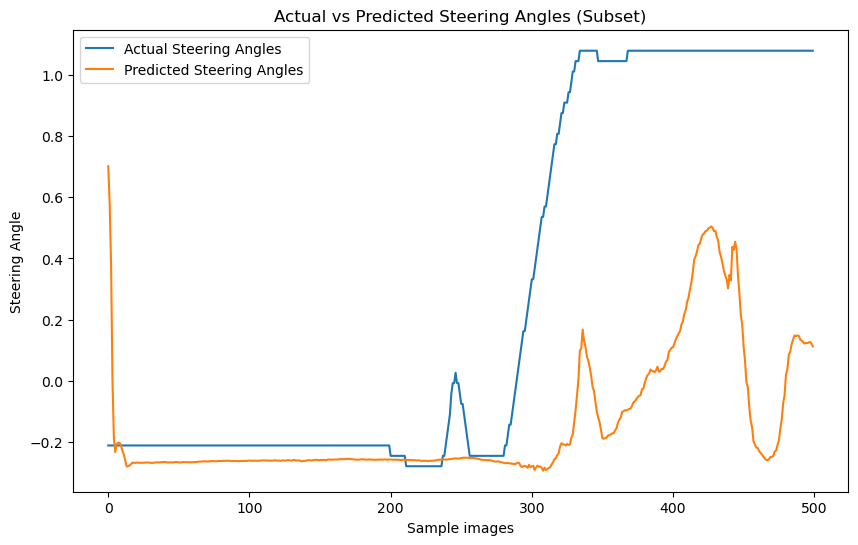

In [158]:
# Plotting actual vs predicted steering angles
subset_size = 500  # Adjust based on how many samples you want to visualize
plt.figure(figsize=(10, 6))
plt.plot(all_targets[:subset_size], label='Actual Steering Angles')
plt.plot(all_predictions[:subset_size], label='Predicted Steering Angles')
plt.legend()
plt.xlabel('Sample images')
plt.ylabel('Steering Angle')
plt.title('Actual vs Predicted Steering Angles (Subset)')
plt.show()